In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import datetime
from datetime import date
import import_ipynb 
import re


from pandasql import sqldf 

---
Câu hỏi: Sinh viên nên thuê trọ vào tháng nào nhất ở một quận cụ thể?
Hướng trả lời:
* Chỉ số x = giá phòng trọ/1m2/1 tháng
* Tháng nên thuê phòng trọ là tháng có chỉ số x trung bình nhỏ nhất (tính từ năm 2018 đến 2022).

In [40]:
df = pd.read_csv('clean_data.csv')
df.head()

,Id,Title,Price(Triệu/tháng),Square(m²),District,City,Date
0,478324,Cho thuê phòng để ở tại 108/64A1 Trần Quang Di...,3.5,18.0,Quận 3,Hồ Chí Minh,2020-06-20
1,728993,Phòng vừa xây xong thoáng mát gần các trường Đ...,3.3,25.0,Quận 7,Hồ Chí Minh,2018-10-17
2,781296,Cần share lại gấp phòng trọ mới thuê tại đường...,3.0,15.0,Quận 10,Hồ Chí Minh,2018-10-05
3,781448,Chính chủ cho thuê căn hộ dịch vụ gần sân bay ...,7.0,27.0,Tân Bình,Hồ Chí Minh,2018-10-06
4,789361,"Phòng cho thuê giá rẻ, Quận Gò Vấp gần chung c...",1.7,12.0,Gò Vấp,Hồ Chí Minh,2018-10-09


In [41]:
def title_clean(feature, df):
	df[feature] = df[feature].str.lower()
	index_lst = []
	e = 'phòng trọ'
	for i in range(df.shape[0]):
		if re.findall(e, df.Title[i]) == []:
			index_lst.append(i)
	df = df.drop(index_lst).reset_index(drop = True)
	return df

In [42]:
# Lọc ra bộ dữ liệu chỉ gồm phòng trọ
df = title_clean('Title', df)

# Xóa những cột mà Price = null và Square = null
df = df[df["Price(Triệu/tháng)"].notna()]
df = df[df["Square(m²)"].notna()]
df.head()

,Id,Title,Price(Triệu/tháng),Square(m²),District,City,Date
0,781296,cần share lại gấp phòng trọ mới thuê tại đường...,3.0,15.0,Quận 10,Hồ Chí Minh,2018-10-05
1,834229,cho thuê phòng trọ quận bình thạnh gần ngã tư ...,1.5,16.0,Bình Thạnh,Hồ Chí Minh,2018-10-11
2,842926,"phòng trọ cách mạng tháng 8, quận 3",4.0,20.0,Quận 3,Hồ Chí Minh,2018-10-01
3,847848,"cho thuê phòng trọ khu bàu cát, p14, q. tân bì...",5.0,25.0,Tân Bình,Hồ Chí Minh,2018-10-01
4,849068,"phòng trọ hẻm 467 lê đức thọ , phường 16, quận...",1.8,20.0,Gò Vấp,Hồ Chí Minh,2018-10-18


In [43]:
# Thêm cột Month, Year
#df['Year'] = df['Date'].str.slice(0,4)
#df['Month'] = df['Date'].str.slice(5,7)
df["Date"] = pd.to_datetime(df["Date"])
year = df['Date'].array
df['Year'] = year[:].year
month = df['Date'].array
df['Month'] = month[:].month

In [44]:
# Thêm cột chỉ số x 
df["X"] = df["Price(Triệu/tháng)"]/df["Square(m²)"]
df = df[["X", "Price(Triệu/tháng)", "Square(m²)", "District", "Month", "Year"]]
df[df["District"] == "Bình Chánh"]
df.rename(columns={'Price(Triệu/tháng)':'Price'},inplace = True)

In [45]:
# pd.set_option("display.max_rows", None)
# Gom cụm theo quận, năm, tháng để xem dữ liệu
query = "SELECT df.X,df.Price, df.District, df.Month, df.Year FROM df GROUP BY District, Year, Month"
sqldf(query, globals())

,X,Price,District,Month,Year
0,0.066667,2.0,Bình Chánh,2,2020
1,0.066667,2.0,Bình Chánh,12,2020
2,0.080000,2.0,Bình Chánh,4,2021
3,0.014000,1.4,Bình Chánh,4,2022
4,0.093750,1.5,Bình Thạnh,10,2018
...,...,...,...,...,...
307,0.125000,4.0,Tân Phú,11,2020
308,0.090000,2.7,Tân Phú,3,2021
309,0.075000,4.5,Tân Phú,6,2021
310,0.120000,1.8,Tân Phú,11,2021


In [46]:
""" 
- Tạo câu truy vấn: gom các tháng của cùng 1 quận lại với nhau (của tất cả các năm từ 2018 - 2022)
- Ví dụ kết quả truy vấn mong đợi:
        ** BẢNG DATA BAN ĐẦU **
+ District    Year     Month   Price    ...
+  A          2018       5      0.1     ...
+  A          2018       8      0.2     ...
+  A          2019       5      0.8     ... 
+  A          2020       8      0.1     ... 
+  A          2021       8      0.1     ...

		** BẢNG KẾT QUẢ **
+ District     Month    Price   ...  (không có cột Year)
+ A              5       0.9    
+ A              8       0.4    ...
"""
# query = "SELECT DISTINCT a.X, a.Price, a.Square, a.District, a.Month \
#         FROM df a \
#         LEFT JOIN df2 b \
#         ON a.Month = b.Month AND a.District = b.District"
# ans = sqldf(query, globals())
# ans[ans["District"] == "Bình Chánh"]
print()

In [47]:
"""       ** BẢNG DATA BAN ĐẦU **
 + District    Year     Month   Price    ...
 +  A          2018       5      0.1     ...
 +  A          2018       8      0.2     ...
 +  A          2019       5      0.8     ... 
 +  A          2020       8      0.1     ... 
 +  A          2021       8      0.1     ...

        ** BẢNG KẾT QUẢ **
 + District     Month    Price   ...  (không có cột Year)
 + A              5       0.9    
 + A              8       0.4    ... (Giả sử tính sum())
"""
result = df.groupby(['District', 'Month']).mean() # tính trung bình chỉ số X của mỗi quận, trên từng tháng, tính từ năm 2018 - 2022
result

X     Price  Square(m²)     Year
District   Month                                         
Bình Chánh 2      0.066667  2.000000   30.000000  2020.00
           4      0.047000  1.700000   62.500000  2021.50
           12     0.066667  2.000000   30.000000  2020.00
Bình Thạnh 1      0.210909  3.440000   17.400000  2020.20
           2      0.123750  2.425000   19.250000  2021.75
...                    ...       ...         ...      ...
Tân Phú    6      0.094318  3.500000   41.000000  2020.50
           8      0.166667  4.000000   24.000000  2020.00
           10     0.108316  2.530000   21.875000  2019.25
           11     0.120333  2.900000   24.000000  2020.00
           12     0.118148  3.033333   25.666667  2019.00

[170 rows x 4 columns]

In [48]:
result.loc["Bình Chánh", :]["X"].idxmin()

4

In [49]:
# Lấy chỉ số X của từng tháng
city_list = df["District"].unique()
city_list
for city in city_list:
	print("Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận %s: Tháng"%city,  
	pd.to_numeric(result.loc[city, :]["X"].idxmin()))

Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Quận 10: Tháng 2
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Bình Thạnh: Tháng 3
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Quận 3: Tháng 5
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Tân Bình: Tháng 2
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Gò Vấp: Tháng 5
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Quận 7: Tháng 2
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Bình Tân: Tháng 8
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Quận 2: Tháng 6
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Hóc Môn: Tháng 10
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Phú Nhuận: Tháng 9
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Quận 1: Tháng 7
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ số X) ở quận Quận 4: Tháng 3
Tháng có giá thuê trọ nhỏ nhất trên 1m2 (hay chỉ s

---

In [50]:
df_info = pd.read_csv('clean_data.csv')
drop_list = df_info[df_info['Price(Triệu/tháng)']>50].index
df_info.drop(index=drop_list,inplace = True)

In [51]:
df_info.head()

,Id,Title,Price(Triệu/tháng),Square(m²),District,City,Date
0,478324,Cho thuê phòng để ở tại 108/64A1 Trần Quang Di...,3.5,18.0,Quận 3,Hồ Chí Minh,2020-06-20
1,728993,Phòng vừa xây xong thoáng mát gần các trường Đ...,3.3,25.0,Quận 7,Hồ Chí Minh,2018-10-17
2,781296,Cần share lại gấp phòng trọ mới thuê tại đường...,3.0,15.0,Quận 10,Hồ Chí Minh,2018-10-05
3,781448,Chính chủ cho thuê căn hộ dịch vụ gần sân bay ...,7.0,27.0,Tân Bình,Hồ Chí Minh,2018-10-06
4,789361,"Phòng cho thuê giá rẻ, Quận Gò Vấp gần chung c...",1.7,12.0,Gò Vấp,Hồ Chí Minh,2018-10-09


In [52]:
# Chuyển sang dạng datetime cho cột Date
df_info["Date"] = df_info["Date"].str.replace('\r','')
df_info["Date"] = df_info["Date"].str.replace(' ','')
df_info["Date"] = pd.to_datetime(df_info["Date"],errors = 'raise')

## Câu hỏi: Chỉ số tăng trưởng giá thuê của các quận

Có một người đang có ý định đầu tư vào lĩnh vực cho thuê phòng trọ ĐƠN cho sinh viên. Sau khi tìm hiểu, người đó nhận ra rằng 3 khu vực có đông sinh viên nhất là Quận Thủ Đức, Quận Bình Thạnh và Quận 7. Để quyết định xem là nên đầu tư vào khu vực nào thì sẽ tốt nhất về lâu dài ( tức là giá thuê và lợi ích có sự tăng trưởng tốt nhất ), người đó muốn nhờ bạn chỉ ra xu hướng giá nhà thuê của các khu vực này theo các năm 2018, 2019, 2020, 2021, 2022. Nên nhớ là sinh viên chỉ có thể chi trả dưới 10 triệu/tháng, hãy tính chỉ số tăng trưởng cho từng quận qua các năm. Công thức của chỉ số này là 0.2diện tích + 0.6giá + 0.2*chỉ số yêu thích (Q1: 1.5 QBT: 1 Q7: 0.5) (mức độ yêu thích của người này với các quận)

### Đầu tiên, lọc ra những bài đăng của 3 quận này

In [53]:
df_q1_bt_q7 = df_info[(df_info['District'] == 'Quận 1') | (df_info['District'] == 'Quận 7') | (df_info['District'] == 'Bình Thạnh')]
df_q1_bt_q7

,Id,Title,Price(Triệu/tháng),Square(m²),District,City,Date
1,728993,Phòng vừa xây xong thoáng mát gần các trường Đ...,3.30,25.0,Quận 7,Hồ Chí Minh,2018-10-17
5,834229,Cho thuê phòng trọ quận Bình Thạnh gần Ngã Tư ...,1.50,16.0,Bình Thạnh,Hồ Chí Minh,2018-10-11
9,836410,☆☆BẠN CÓ MUỐN Ở TRONG NHÀ NÀY KHÔNG? ☆NHÀ MẶT ...,6.00,20.0,Bình Thạnh,Hồ Chí Minh,2018-09-29
10,836668,Cho thuê KTX máy lạnh 450k/tháng ở xô viết ngh...,0.45,40.0,Bình Thạnh,Hồ Chí Minh,2018-09-29
13,840923,Cho thuê phòng đầy đủ tiện nghi ở cư xá Nguyên...,4.50,35.0,Bình Thạnh,Hồ Chí Minh,2018-10-13
...,...,...,...,...,...,...,...
1113,2094225,Cho thuê phòng trọ có gác giá rẻ nhưng đầy đủ ...,3.70,15.0,Quận 7,Hồ Chí Minh,2022-10-24
1117,2109043,"Căn hộ 2T bancony ngay chợ Bà Chiểu, sát hàng ...",6.50,25.0,Bình Thạnh,Hồ Chí Minh,2022-11-11
1118,2109867,Căn hộ đẹp Tràn Ngập Tiện Nghi ngay trung tâm Q.1,6.00,30.0,Quận 1,Hồ Chí Minh,2022-11-12
1122,2111362,"Phòng cho thuê quận Bình Thạnh, đường Ung Văn ...",4.00,28.0,Bình Thạnh,Hồ Chí Minh,2022-11-14


Ta sẽ loại đi những bài đăng ở ghép hay ở KTX (vì những bài đăng này có giá rẻ nhưng diện tích lại lớn, ảnh hưởng đến kết quả)

In [54]:
drop_list = []
for i in df_q1_bt_q7.index:
    title = df_q1_bt_q7.loc[i]['Title']
    if 'KTX' in title or 'ktx' in title or 'Kí túc xá' in title or 'kí túc xá' in title or 'ghép' in title or 'Ghép' in title:
        drop_list.append(i)

In [55]:
df_q1_bt_q7.drop(index = drop_list,inplace = True)

C:\Users\laito\AppData\Local\Temp\ipykernel_13468\2620826261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1_bt_q7.drop(index = drop_list,inplace = True)


Lọc ra những phòng có giá dưới 10 triệu

In [56]:
df_q1_bt_q7 = df_q1_bt_q7[df_q1_bt_q7['Price(Triệu/tháng)'] < 10]

Ta thêm cột Year vào dataframe để phân loại theo năm

In [57]:
df_q1_bt_q7['Year'] = df_q1_bt_q7['Date'].array.year

C:\Users\laito\AppData\Local\Temp\ipykernel_13468\151600109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1_bt_q7['Year'] = df_q1_bt_q7['Date'].array.year


Để xem những phân khúc giá nhà có số lượng phân bố như thế nào, ta sẽ vẽ biểu đồ

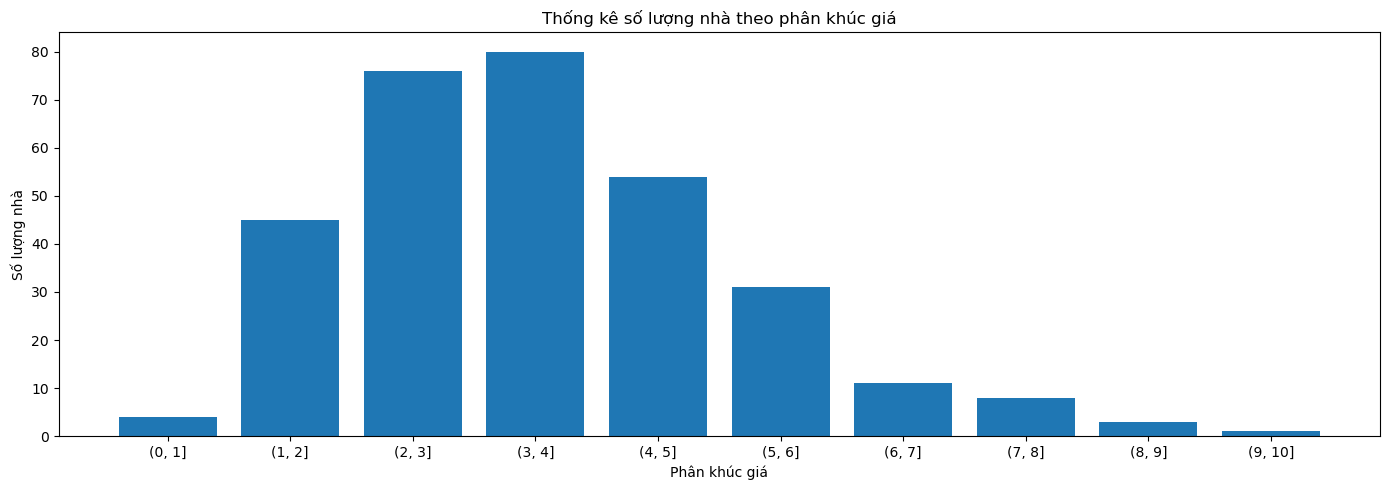

In [58]:
price_list_range = np.arange(0,11,1)

range_price_10 = pd.cut(df_q1_bt_q7["Price(Triệu/tháng)"],bins = price_list_range)

count_price_10 = range_price_10.value_counts().sort_index()
count_price_10 = count_price_10.reset_index()
count_price_10.columns = ["Range","So luong"]
count_price_10["Range"] = count_price_10["Range"].astype(str)

plt.subplots(figsize = (14,5))
plt.bar(count_price_10["Range"],count_price_10["So luong"])

plt.xlabel('Phân khúc giá')
plt.ylabel('Số lượng nhà')
plt.title('Thống kê số lượng nhà theo phân khúc giá')
plt.tight_layout()
plt.show()

Ta thấy đồ thị có dạng phân phối chuẩn (lệch phải), tập trung nhiều ở mức giá 3-4 triệu đồng. Có một số điểm như từ 0-1 triệu hay 8-9 triệu có số lượng tương đối, nếu lấy trung bình sẽ ảnh hưởng đến dữ liệu

Ta sẽ lấy giá trị trung vị để tránh bị ảnh hưởng

In [59]:
df_price = df_q1_bt_q7.groupby(['Year','District'])['Price(Triệu/tháng)'].agg(['median'])
df_price.rename(columns = {'median': 'medianprice'},inplace = True)
df_price

medianprice
Year District               
2018 Bình Thạnh         3.85
     Quận 1             5.90
     Quận 7             3.85
2019 Bình Thạnh         3.75
     Quận 1             3.90
     Quận 7             3.50
2020 Bình Thạnh         3.25
     Quận 1             3.50
     Quận 7             2.65
2021 Bình Thạnh         3.50
     Quận 1             4.75
     Quận 7             3.80
2022 Bình Thạnh         4.00
     Quận 1             4.50
     Quận 7             3.55

Làm tương tự với diện tích

In [60]:
sorted(df_q1_bt_q7["Square(m²)"].unique())

[1.0,
 5.0,
 6.0,
 8.0,
 9.0,
 10.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 30.0,
 32.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 40.0,
 45.0,
 48.0,
 50.0,
 60.0,
 80.0,
 90.0,
 118.0]

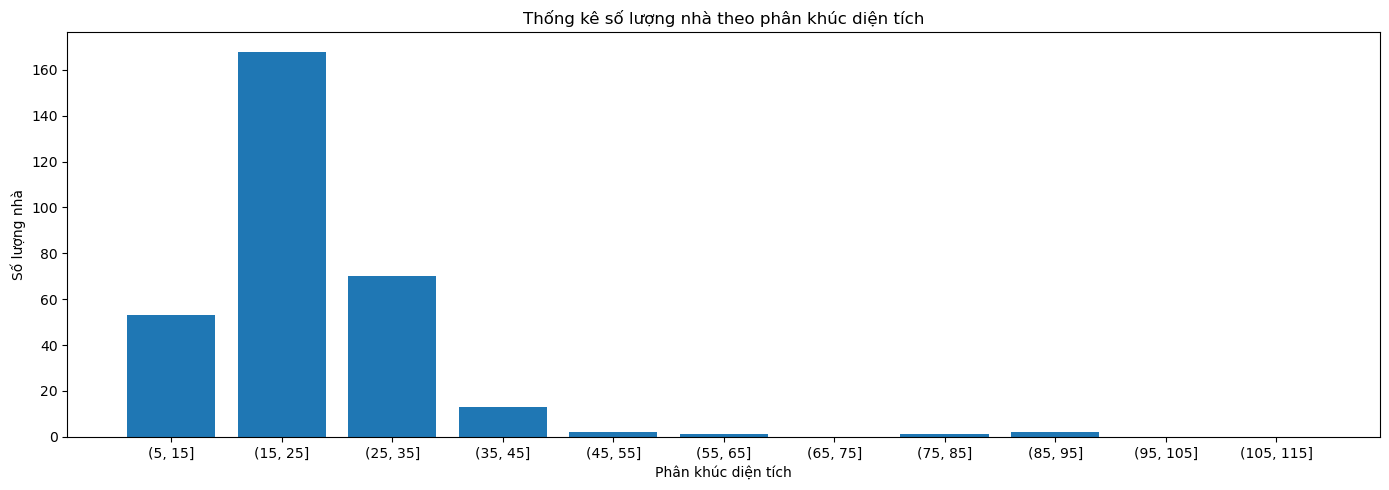

In [61]:
price_list_range = np.arange(5,118,10)

range_price_10 = pd.cut(df_q1_bt_q7["Square(m²)"],bins = price_list_range)

count_price_10 = range_price_10.value_counts().sort_index()
count_price_10 = count_price_10.reset_index()
count_price_10.columns = ["Range","So luong"]
count_price_10["Range"] = count_price_10["Range"].astype(str)

plt.subplots(figsize = (14,5))
plt.bar(count_price_10["Range"],count_price_10["So luong"])

plt.xlabel('Phân khúc diện tích')
plt.ylabel('Số lượng nhà')
plt.title('Thống kê số lượng nhà theo phân khúc diện tích')
plt.tight_layout()
plt.show()

In [62]:
df_square = df_q1_bt_q7.groupby(['Year','District'])['Square(m²)'].agg(['median'])
df_square['median'] = df_square['median']/10
df_square.rename(columns = {'median': 'mediansquare'},inplace = True)
df_square

mediansquare
Year District                
2018 Bình Thạnh          2.00
     Quận 1              2.40
     Quận 7              2.50
2019 Bình Thạnh          2.50
     Quận 1              2.35
     Quận 7              2.00
2020 Bình Thạnh          2.00
     Quận 1              2.00
     Quận 7              2.00
2021 Bình Thạnh          2.00
     Quận 1              2.00
     Quận 7              2.20
2022 Bình Thạnh          2.50
     Quận 1              1.90
     Quận 7              1.50

Để tiện cho việc tính toán, ta sẽ thêm cột median square vào df_price

In [63]:
df_price['mediansquare'] = df_square['mediansquare']

In [64]:
df_price['fav rate'] = [1,1.5,0.5] * 5
df_price

medianprice  mediansquare  fav rate
Year District                                       
2018 Bình Thạnh         3.85          2.00       1.0
     Quận 1             5.90          2.40       1.5
     Quận 7             3.85          2.50       0.5
2019 Bình Thạnh         3.75          2.50       1.0
     Quận 1             3.90          2.35       1.5
     Quận 7             3.50          2.00       0.5
2020 Bình Thạnh         3.25          2.00       1.0
     Quận 1             3.50          2.00       1.5
     Quận 7             2.65          2.00       0.5
2021 Bình Thạnh         3.50          2.00       1.0
     Quận 1             4.75          2.00       1.5
     Quận 7             3.80          2.20       0.5
2022 Bình Thạnh         4.00          2.50       1.0
     Quận 1             4.50          1.90       1.5
     Quận 7             3.55          1.50       0.5

Sau đó, ta tính cột chỉ số tăng trưởng

In [65]:
df_price['growth rate'] = df_price['medianprice']*0.6 + df_price['mediansquare']*0.2 + df_price['fav rate'] 

Ta sẽ vẽ biểu đồ đường để thể hiện chỉ số tăng trưởng của từng quận qua các năm

In [66]:
bt = df_price.query('District == "Bình Thạnh"').reset_index()
td = df_price.query('District == "Quận 7"').reset_index()
q1 = df_price.query('District == "Quận 1"').reset_index()

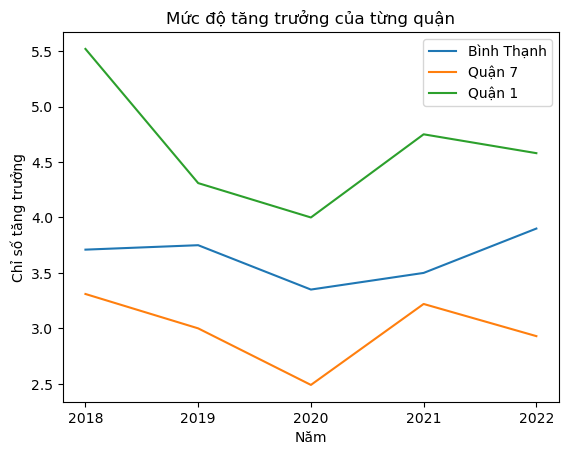

In [67]:
bt['Year'] = bt['Year'].astype(str)
td['Year'] = td['Year'].astype(str)
q1['Year'] = q1['Year'].astype(str)
plt.plot(bt['Year'],bt['growth rate'],label = 'Bình Thạnh')
plt.plot(td['Year'],td['growth rate'],label = 'Quận 7')
plt.plot(q1['Year'],q1['growth rate'],label = 'Quận 1')
plt.xlabel('Năm')
plt.ylabel('Chỉ số tăng trưởng')
plt.title('Mức độ tăng trưởng của từng quận')
plt.legend()
plt.show()

Ta thấy vào năm 2018, Quận 1 có chỉ số cao hơn hẳn 2 quận còn lại nhưng qua năm lại giảm rất mạnh ( có thể là do ourlier ), trong khi 2 quận kia tăng nhẹ. Năm 2020 do dịch nên cả 3 quận đều giảm. Qua năm 2021 thì Quận 1 và Quận 7 tăng khá mạnh, còn Bình Thạnh tăng nhẹ. Năm 2022 Quận 7 đang có chỉ số xuống, quận 1 thì tăng nhẹ, còn Bình Thạnh lại có sự tăng đột biến

Sự biến động của quận 1 khá lớn, nếu xét cả 5 năm thì Quận 1 thậm chí còn kém hơn so với lúc đầu (năm 2018), như vậy sẽ rất bất ổn nếu đầu tư vào đây.

Quận 7 cũng có sự tăng trưởng nhưng giá trị của chỉ số lại khá thấp, thậm chí năm 2022 chỉ số này còn có xu hướng đi xuống nên có vẻ cũng không nhiều lợi ích lắm nếu đầu tư vào đây

Lời khuyên là nên đầu tư vào Bình Thạnh. Ta quan sát thấy rằng tuy chỉ số có giảm ở năm 2018 - 2020 nhưng sau dịch, Quận này lại có sự tăng trưởng ổn định, thậm chí tăng rất mạnh ở năm 2022. Giá trị của chỉ số tăng trưởng cũng vô cùng tốt và nhiều khả quan.

## Câu hỏi: Mối liên hệ giữa số bài đăng và giá phòng
**Liệu có phải càng nhiều bài đăng ( số lượng phòng trống nhiều -> mức độ cung lớn) thì giá phòng càng rẻ hay không?. Hãy liệt kê số lượng bài đăng theo từng tháng và tính giá trung bình để trả lời câu hỏi trên**

Vì xét theo tháng nên ta sẽ thêm cột tháng vào để tiện xử lý

In [68]:
df_info['Month'] = df_info['Date'].array.month
df_info['Year'] = df_info['Date'].array.year
df_info

,Id,Title,Price(Triệu/tháng),Square(m²),District,City,Date,Month,Year
0,478324,Cho thuê phòng để ở tại 108/64A1 Trần Quang Di...,3.5,18.0,Quận 3,Hồ Chí Minh,2020-06-20,6,2020
1,728993,Phòng vừa xây xong thoáng mát gần các trường Đ...,3.3,25.0,Quận 7,Hồ Chí Minh,2018-10-17,10,2018
2,781296,Cần share lại gấp phòng trọ mới thuê tại đường...,3.0,15.0,Quận 10,Hồ Chí Minh,2018-10-05,10,2018
3,781448,Chính chủ cho thuê căn hộ dịch vụ gần sân bay ...,7.0,27.0,Tân Bình,Hồ Chí Minh,2018-10-06,10,2018
4,789361,"Phòng cho thuê giá rẻ, Quận Gò Vấp gần chung c...",1.7,12.0,Gò Vấp,Hồ Chí Minh,2018-10-09,10,2018
...,...,...,...,...,...,...,...,...,...
1126,2119311,"Cho thuê phòng ĐẸP 16m2 đường Thành Thái-Q10, ...",5.0,16.0,Quận 10,Hồ Chí Minh,2022-11-25,11,2022
1127,2122158,Thuê phòng 2.5 triệu 20m2 căn bìa tầng trệt gầ...,2.5,20.0,Quận 4,Hồ Chí Minh,2022-11-29,11,2022
1128,2127186,Cho thuê mặt bằng KD và phòng trọ số 36/66 Ngu...,2.0,6.0,Bình Thạnh,Hồ Chí Minh,2022-12-07,12,2022
1129,2127880,"Phòng nội thất cao cấp ưu tiên nữ, gần vòng xo...",2.9,22.0,Tân Phú,Hồ Chí Minh,2022-12-08,12,2022


Ta tạo 1 dataframe gồm 2 cột là số lượng nhà đăng trong tháng và giá trung bình, index là các tháng trong năm

In [69]:
df_num_price = pd.DataFrame([],index = sorted(df_info['Month'].unique()))

Thống kê số lượng phòng đăng lên theo tháng

In [70]:
df_num_price['Num'] = df_info['Month'].value_counts().sort_index()
df_num_price['Num']

1      51
2      67
3     132
4      58
5     107
6      99
7      88
8      50
9      59
10    245
11     86
12     89
Name: Num, dtype: int64

Sau đó, ta tính giá trung bình của tiền thuê nhà theo tháng

In [71]:
df_num_price['AvePrice'] = df_info.groupby(['Month'])['Price(Triệu/tháng)'].mean()

In [72]:

df_num_price

,Num,AvePrice
1,51,2.824510
2,67,3.174627
3,132,3.161742
4,58,3.101724
5,107,3.955047
6,99,3.166162
7,88,4.356250
8,50,3.289000
9,59,3.423729
10,245,4.809265


Ta sẽ vẽ biểu đồ thể hiện mối liên hệ giữa số lượng bài đăng trong một tháng và giá trung bình của tháng đó

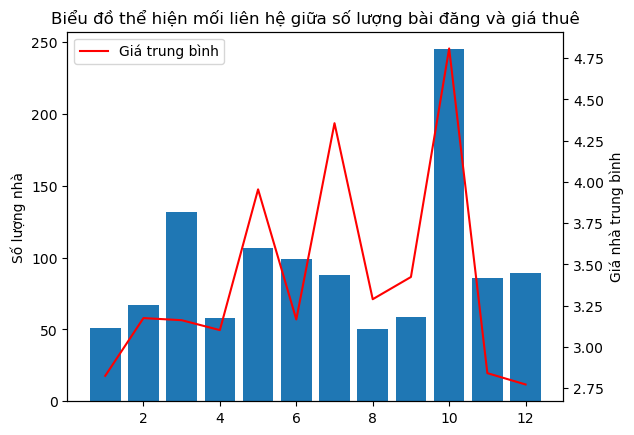

In [73]:
fig,ax = plt.subplots()
ax.bar(df_num_price.index,df_num_price['Num'])

ax2=ax.twinx()
ax2.plot(df_num_price.index,df_num_price['AvePrice'],color="red",label = 'Giá trung bình')

plt.xlabel('Tháng')
ax.set_ylabel('Số lượng nhà')
ax2.set_ylabel('Giá nhà trung bình')
plt.title('Biểu đồ thể hiện mối liên hệ giữa số lượng bài đăng và giá thuê')
plt.legend()
plt.show()


Ta thấy rằng ở tháng 10 có số bài đăng nhiều nhất cũng như mức giá cao nhất. Điều này cũng khá dễ hiểu vì đây là thời điểm nhập học nên nhu cầu ở trọ khá cao, lợi dụng điều đó nên giá cả cũng tăng theo. Còn ở những thời điểm khác thì giá nhà và số lượng bài đăng không theo quy luật nào hết. Một số tháng có giá trung bình thấp như tháng 11 (nhu cầu thuê đã ít đi nhiều) hay tháng 6 ( thời điểm trả phòng nên phải hạ giá để lôi kéo người thuê).

**Liệu có phải vào lúc nào số lượng bài đăng của các tháng cũng đều như trên? Ta sẽ xem qua từng năm thì các tháng sẽ thay đổi như thế nào**

In [74]:
df_year_month = pd.DataFrame([],index = [2018,2019,2020,2021,2022])

for i in sorted(df_info['Month'].unique()):
    month_count = df_info[df_info['Month'] == i]
    month_count = month_count['Year'].value_counts()
    df_year_month[i] = month_count
df_year_month

,1,2,3,4,5,6,7,8,9,10,11,12
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,162,16,22
2019,17.0,12.0,45.0,15.0,24.0,25.0,20.0,10.0,23,39,16,20
2020,11.0,31.0,18.0,10.0,47.0,41.0,50.0,28.0,17,24,20,29
2021,19.0,11.0,44.0,18.0,33.0,25.0,5.0,1.0,4,10,22,15
2022,4.0,13.0,25.0,15.0,3.0,8.0,13.0,11.0,3,10,12,3


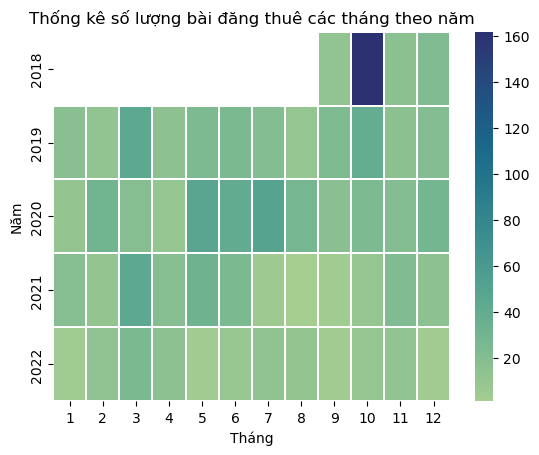

In [78]:
sns.heatmap(df_year_month, linewidth=.25, cmap="crest")
plt.xlabel('Tháng')
plt.ylabel('Năm')
plt.title('Thống kê số lượng bài đăng thuê các tháng theo năm')
plt.show()

Vào năm 2018, ta thấy số lượng bài đăng vào tháng 10 là chủ yếu, từ tháng 1 - > 9 thì không có dữ liệu, điều này cũng có thể lý giải tại sao biểu đồ số lượng bài theo tháng ở trên 1 -> 9 khá ít còn thấng 10 lại nhiều. Điều bất ngờ là ở các năm sau thì tháng 10 không phải là tháng đăng bài nhiều nhất mà tầm tháng 2,3 (sau Tết). Có thể học kì mới nên sinh viên trả phòng nhiều + nhu cầu tìm kiếm phòng cao (khác với tháng 5,6 khi sinh viên trả phòng nhưng về quê)